In [37]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np

#单个cell输出多个变量
# https://blog.csdn.net/weixin_43360896/article/details/114653915
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


batch_size_train = 32 # We use a small batch size here for training
batch_size_test = 32 #
latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', train=True, download=True,transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', train=False, download=True,transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size_test, shuffle=True)

In [2]:
import matplotlib.pyplot as plt
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [3]:
example_data.shape

torch.Size([32, 1, 28, 28])

In [4]:
example_targets.shape

torch.Size([32])

可视化MNIST数据

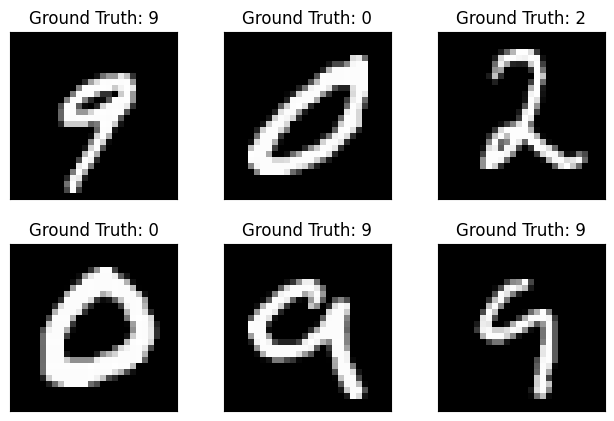

In [42]:
# https://nextjournal.com/gkoehler/pytorch-mnist
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## 构建VAE网络

一个基础编码器的结构图

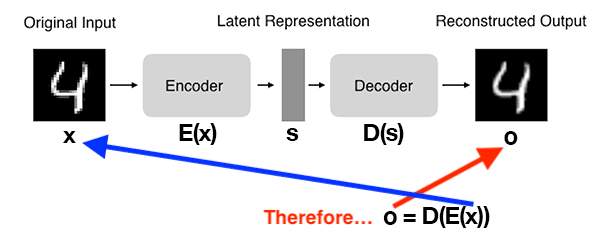

Figure : Architecture of Autoencoder (inspired by [Hubens, “Deep Inside: Autoencoders,” Towards Data Science, 2018](https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f)).


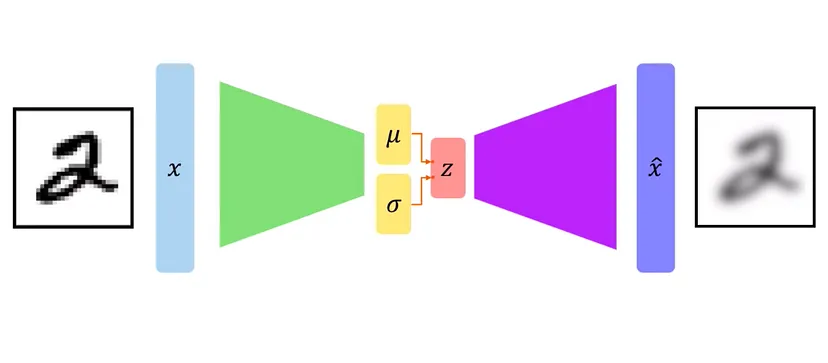

Figure : A Variational Autoencoder ([Source](https://www.youtube.com/watch?v=rZufA635dq4&ab_channel=AlexanderAmini))

In [22]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super( ).__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size=(3,3), stride=(1,1), padding=(1,1))   
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1)   
        self.conv3 = nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1)   
        self.conv4 = nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1) 
        self.fc_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*14*14, 32),
            nn.ReLU()
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.fc_1(x)
        
        return x
 
class LatentSpace(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.z_mu = nn.Linear(32, latent_dim)
        self.z_sigma = nn.Linear(32, latent_dim) 
        
    def forward(self, x):
        z_mu = self.z_mu(x)
        z_sigma  = self.z_sigma(x)
        eps = torch.randn_like(z_mu)
        
        return z_mu, z_sigma, z_mu+torch.exp(0.5 *z_sigma) * eps

        
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc_1 = nn.Sequential(
            nn.Linear(2, 64*14*14),
            nn.ReLU()
        )
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, padding=1, stride=2)
        # self.act = nn.Sigmoid()
    def forward(self, x):
        batch_size, n_channels = x.shape
        x = self.fc_1(x)
        x = x.view(batch_size, 64, 14, 14)
        # x = x.reshape(batch_size, 64, 14, 14)
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        return x 
        
        
class VAE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = Encoder()
        self.latent_space = LatentSpace()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        z_mu, z_sigma, x = self.latent_space(x)
        x = self.decoder(x)
        return  z_mu, z_sigma, x

In [ ]:
def summary_vae():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = VAE().to(device) #using cpu here
    print(summary(model, input_size=(1, 1, 28, 28)))

summary_vae()

In [9]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device) #using cpu here
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()

            mean, log_var, x_hat  = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size_train))
    return overall_loss

train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  177.5838907785324
	Epoch 2 	Average Loss:  159.53832612500756
	Epoch 3 	Average Loss:  156.01649076528966
	Epoch 4 	Average Loss:  153.9012296263411
	Epoch 5 	Average Loss:  152.58184547790722
	Epoch 6 	Average Loss:  151.50753704791643
	Epoch 7 	Average Loss:  150.58947584137974
	Epoch 8 	Average Loss:  149.89493119882036
	Epoch 9 	Average Loss:  149.35072776932853
	Epoch 10 	Average Loss:  148.85812921432446
	Epoch 11 	Average Loss:  148.4668276897744
	Epoch 12 	Average Loss:  148.08559169789643
	Epoch 13 	Average Loss:  147.60518100701884
	Epoch 14 	Average Loss:  147.3286032580006
	Epoch 15 	Average Loss:  147.0679077588125
	Epoch 16 	Average Loss:  146.88742205885455
	Epoch 17 	Average Loss:  146.67282628046155
	Epoch 18 	Average Loss:  146.3598822936686
	Epoch 19 	Average Loss:  146.28520457492695
	Epoch 20 	Average Loss:  145.9932026695162
	Epoch 21 	Average Loss:  145.80830017708664
	Epoch 22 	Average Loss:  145.6225702169738
	Epoch 23 	Average Loss:  1

8560479.648925781

训练完成后，可以从潜在空间中做采样，然后经过decoder，得到采用结果，看一下我们从潜在空间中的采用结果，以观察我们的训练结果。

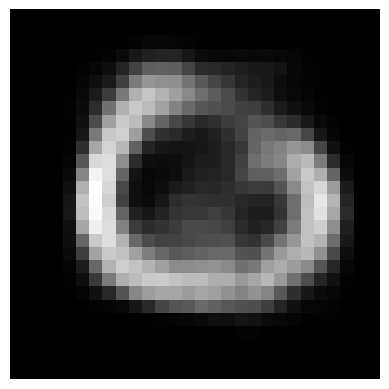

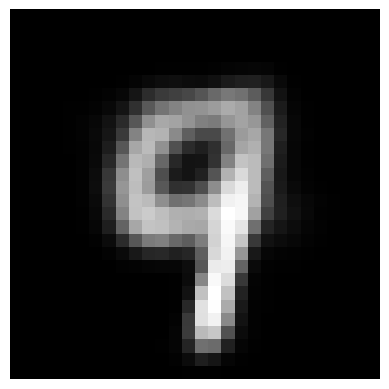

(None, None)

In [33]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

均值和方差的取值范围修改为[-1,1],展示一下潜在空间的内容

/opt/anaconda3/envs/sd-webui/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


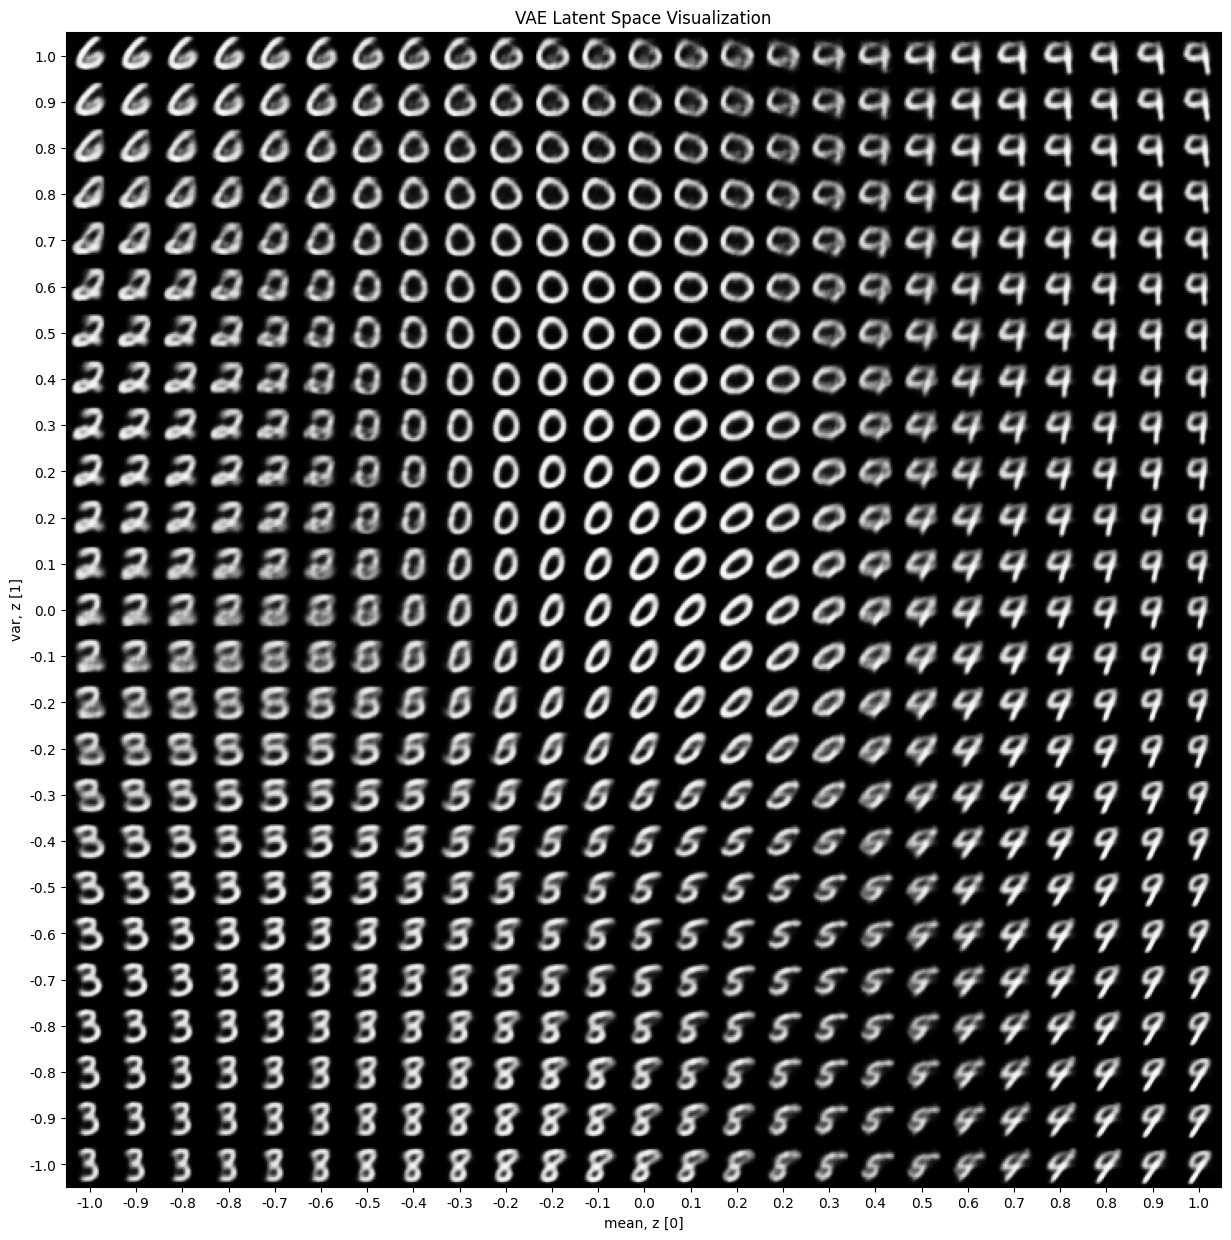

In [35]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

均值和方差的取值范围修改为[-5,5],展示一下潜在空间的内容

/opt/anaconda3/envs/sd-webui/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


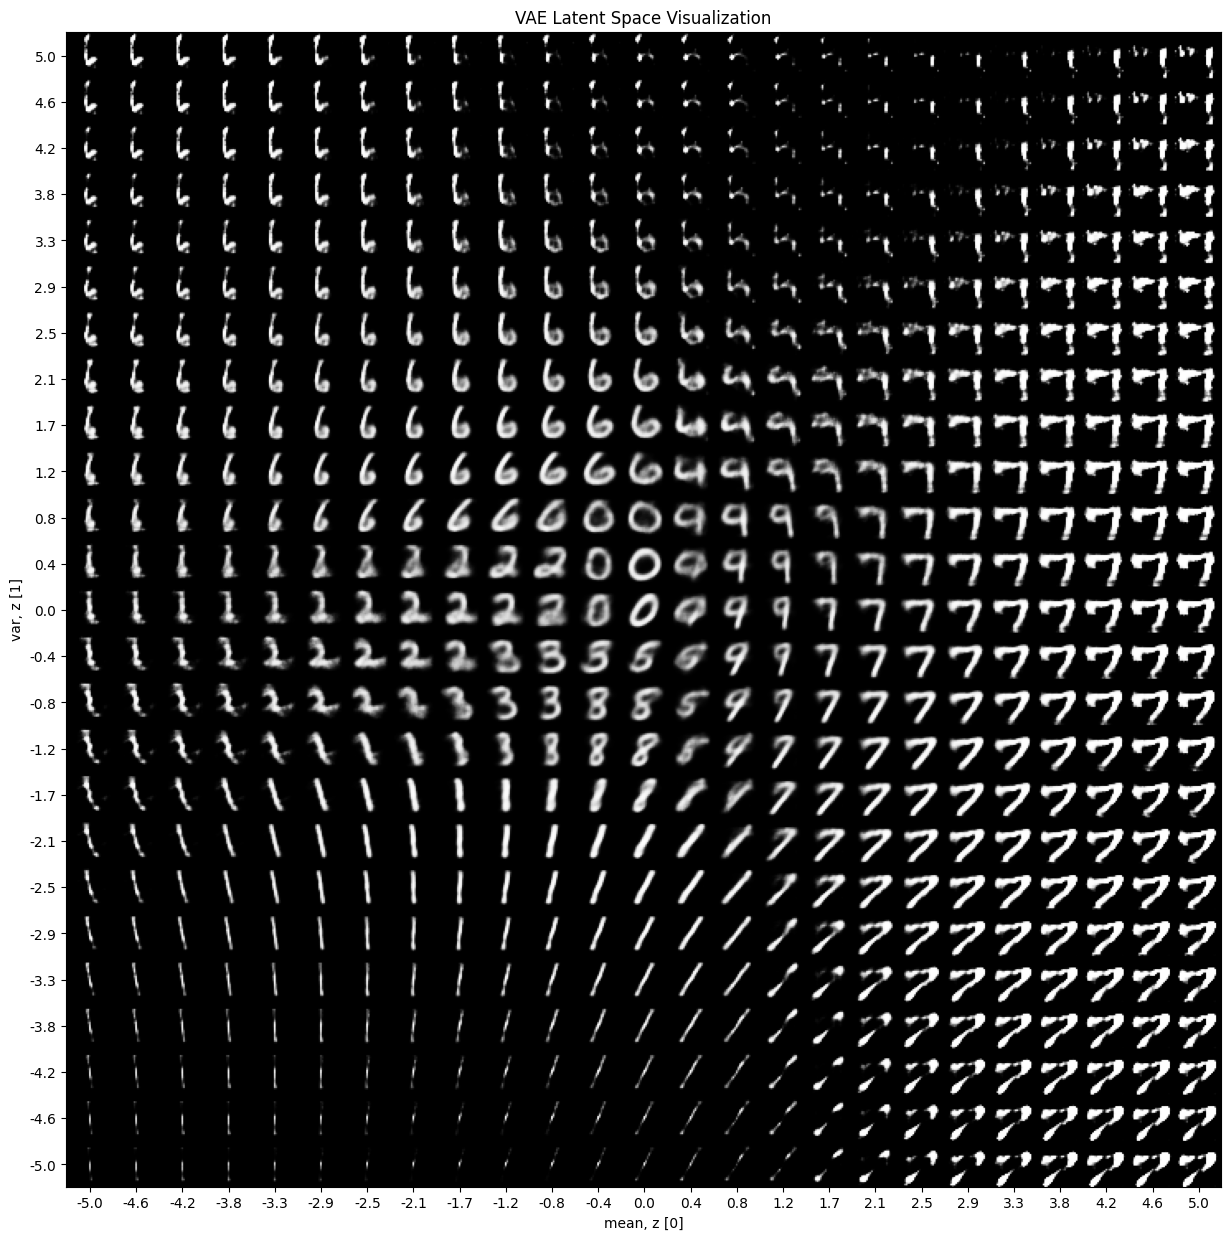

In [36]:
plot_latent_space(model,scale=5)

## 思考
- 潜在空间的维度（latent_dim=2），可以修改为64,128等，在训练看看结果。

## 参考
- Variational Autoencoder (VAE) — PyTorch Tutorial | https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
  - 主要参考，图片展示+pytorch的部分代码

- Introduction to Autoencoders | https://pyimagesearch.com/2023/07/10/introduction-to-autoencoders/
  - 介绍了各种编码器